# Partial information of circulating isolates
The model will be trained on dataset consisting of genetic and antigenic information of historical isolates as well as x% of randomly selected circulating isolates, where x was varied from 10% to 50%. The simulations will be repeated for 50 Monte Carlo runs. The MAE performance of the model will be computed for 14 test seasons from 2014NH to 2020SH

Note: Run this notebook after running notebook "Fig2_model_evaluation".

## Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [3]:
mut_mat       = "GIAG010101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',
                 'serumPassCat'
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

perc_circ_train_all = [10, 20, 30, 40, 50]  # percentage of circulating isolates in training dataset

n_run_start = 0     # No. of simulation runs as well as
n_run_end   = 50    # random selection of circulating isolates

## Paths and filenames

In [4]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig7_circIsolatesTrain/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
test_fn = path_result + "SuppFig7_circIsolatesTrain.csv"   # to save performance scores for test dataset
fig_fn  = path_result + 'SuppFig7_circIsolatesTrain.svg'   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Function to evaluate effect of including circulating isolates in training dataset
- For each percent of circulating isolates for training
    - For each test season from 2014NH to 2020SH
        - Split the data into training and test datasets
        - Prepare encoded inputs (genetic difference and metadata features)
        - Train and evaluate the model
        - Compute predictive performance
        - Save the predictions
    - Compute average predictive performance

In [5]:
def circIsolatesTrain(run):
    '''
    Random selection of titers per season in training dataset depends on 'run' used as SEED
    '''
    
    '''
    Percentage of circulating virus isolates in training dataset
    '''
    for perc_circ_train in perc_circ_train_all:

        '''
        Test Seasons
        '''
        # to collect actuals and predictions for micro-averaged scores over all test seasons
        actual_all  = {}
        predict_all = {}

        # loop through test seasons
        for test_season in Test_Seasons:
            print("% circulating train: ", perc_circ_train,
                  "%,   test season: ", test_season)

            '''
            Train Test Split
                - based on seasonal framework
                - Train: past virus isolates paired with past sera
                - Test: circulating virus isolates paired with past sera
            '''
            ind_train, ind_test = utilities.circIsolatesTrain_seasonal_trainTestSplit(data[['virus', 'serum', 'virusDate', 'serumDate']],
                                                                                      test_season,
                                                                                      circ_train=perc_circ_train,
                                                                                      random_state=run)

            # training dataset
            data_train = data.iloc[ind_train].copy()
            data_train.reset_index(drop=True, inplace=True)

            # test dataset
            data_test = data.iloc[ind_test].copy()
            data_test.reset_index(drop=True, inplace=True)


            '''
            Input features (genetic difference)
            '''
            # training dataset
            X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                                   index=data_train.index,
                                   columns=HA1_features)
            X_train.fillna(0, inplace=True)   # replace nan with 0

            # test dataset
            X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                                   index=data_test.index,
                                   columns=HA1_features)
            X_test.fillna(0, inplace=True)   # replace nan with 0


            '''
            Input features (metadata features)
            '''
            X_train_meta = data_train[meta_features].fillna('None').astype('str')
            X_test_meta  = data_test[meta_features].fillna('None').astype('str')


            # one hot encoding
            ohe = OneHotEncoder(handle_unknown='ignore')
            X_train_meta = ohe.fit_transform(X_train_meta).toarray()
            X_test_meta  = ohe.transform(X_test_meta).toarray()

            X_train = np.hstack((X_train.values, X_train_meta))
            X_test  = np.hstack((X_test.values, X_test_meta))
            
            
            '''
            Target
            '''
            y_train = data_train.nht.values
            y_test  = data_test.nht.values


            del X_train_meta, X_test_meta, data_train, data_test
            gc.collect()


            '''
            Training and evaluation
            '''
            # optimized model
            model = getattr(model_utilities, f"model_{model_name}")
            results = model(X_train,
                            y_train,
                            X_test = X_test)


            '''
            Test Scores
            '''
            cols       = ['mut_mat', 'model', 'metadata', 'run', 'circ_train', 'season']
            col_values = [mut_mat, model_name, metadata, run, f'{perc_circ_train}%', test_season]
            utilities.compute_scores(y_test, results['pred_test'], test_fn, col=cols, col_val=col_values)


            '''
            Save actuals and predictions
            '''
            actual_all[f'{test_season}']  = y_test
            predict_all[f'{test_season}'] = results['pred_test']
            

            #################
            # End season loop
            #################


        '''
        Micro-average over seasons
        '''
        actual  = np.concatenate(list(actual_all.values()))
        predict = np.concatenate(list(predict_all.values()))

        # Test scores
        col_values = [mut_mat, model_name, metadata, run, f'{perc_circ_train}%', 'Average']
        utilities.compute_scores(actual, predict, test_fn, col=cols, col_val=col_values)
        
        #################################
        # loop over perc_circ_train end
        #################################


## Parallel Monte-Carlo runs

In [8]:
Parallel(n_jobs=5, verbose=1)(delayed(circIsolatesTrain)(run) for run in range(n_run_start, n_run_end))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


% circulating train:  10 %,   test season:  2014NH
Time for training: 296.0552399158478
% circulating train:  10 %,   test season:  2014SH
Time for training: 468.2435998916626
% circulating train:  10 %,   test season:  2015NH
Time for training: 766.7724993228912
% circulating train:  10 %,   test season:  2015SH
Time for training: 985.2060105800629
% circulating train:  10 %,   test season:  2016NH
Time for training: 1155.2178270816803
% circulating train:  10 %,   test season:  2016SH
Time for training: 1259.217924118042
% circulating train:  10 %,   test season:  2017NH
Time for training: 1443.9852917194366
% circulating train:  10 %,   test season:  2017SH
Time for training: 1893.7666563987732
% circulating train:  10 %,   test season:  2018NH
Time for training: 2026.9606704711914
% circulating train:  10 %,   test season:  2018SH
Time for training: 2230.837436437607
% circulating train:  10 %,   test season:  2019NH
Time for training: 2417.4023530483246
% circulating train:  10 %,

% circulating train:  20 %,   test season:  % circulating train:  10 %,   test season:  2014NH
Time for training: 302.3067147731781
% circulating train:  10 %,   test season:  2014SH
Time for training: 469.2278482913971
% circulating train:  10 %,   test season:  2015NH
Time for training: 750.4689214229584
% circulating train:  10 %,   test season:  2015SH
Time for training: 970.8158724308014
% circulating train:  10 %,   test season:  2016NH
Time for training: 1120.8757894039154
% circulating train:  10 %,   test season:  2016SH
Time for training: 1254.185082435608
% circulating train:  10 %,   test season:  2017NH
Time for training: 1482.7297539710999
% circulating train:  10 %,   test season:  2017SH
Time for training: 1931.6273880004883
% circulating train:  10 %,   test season:  2018NH
Time for training: 2097.789274930954
% circulating train:  10 %,   test season:  2018SH
Time for training: 2238.7977476119995
% circulating train:  10 %,   test season:  2019NH
Time for training: 24

% circulating train:  10 %,   test season:  2014NH
Time for training: 293.75970244407654
% circulating train:  10 %,   test season:  2014SH
Time for training: 464.5302450656891
% circulating train:  10 %,   test season:  2015NH
Time for training: 747.3454723358154
% circulating train:  10 %,   test season:  2015SH
Time for training: 971.7701518535614
% circulating train:  10 %,   test season:  2016NH
Time for training: 1166.8264203071594
% circulating train:  10 %,   test season:  2016SH
Time for training: 1272.2960965633392
% circulating train:  10 %,   test season:  2017NH
Time for training: 1463.0312716960907
% circulating train:  10 %,   test season:  2017SH
Time for training: 1909.2452247142792
% circulating train:  10 %,   test season:  2018NH
Time for training: 2044.5236468315125
% circulating train:  10 %,   test season:  2018SH
Time for training: 2233.7536537647247
% circulating train:  10 %,   test season:  2019NH
Time for training: 2373.4887301921844
% circulating train:  10

2018NH
Time for training: 2015.1134712696075
% circulating train:  20 %,   test season:  2018SH
Time for training: 2177.802256822586
% circulating train:  20 %,   test season:  2019NH
Time for training: 2428.06977891922
% circulating train:  20 %,   test season:  2019SH
Time for training: 2818.7368252277374
% circulating train:  20 %,   test season:  2020NH
Time for training: 3292.2175438404083
% circulating train:  20 %,   test season:  2020SH
Time for training: 3792.3440566062927
% circulating train:  30 %,   test season:  2014NH
Time for training: 317.761465549469
% circulating train:  30 %,   test season:  2014SH
Time for training: 515.1443407535553
% circulating train:  30 %,   test season:  2015NH
Time for training: 776.3124055862427
% circulating train:  30 %,   test season:  2015SH
Time for training: 1004.1359989643097
% circulating train:  30 %,   test season:  2016NH
Time for training: 1159.8413560390472
% circulating train:  30 %,   test season:  2016SH
Time for training: 12

Time for training: 2042.7714881896973
% circulating train:  20 %,   test season:  2018SH
Time for training: 2244.8016352653503
% circulating train:  20 %,   test season:  2019NH
Time for training: 2418.687747001648
% circulating train:  20 %,   test season:  2019SH
Time for training: 2795.115129470825
% circulating train:  20 %,   test season:  2020NH
Time for training: 3250.938082933426
% circulating train:  20 %,   test season:  2020SH
Time for training: 3790.274968624115
% circulating train:  30 %,   test season:  2014NH
Time for training: 320.75336146354675
% circulating train:  30 %,   test season:  2014SH
Time for training: 512.9899256229401
% circulating train:  30 %,   test season:  2015NH
Time for training: 779.8266923427582
% circulating train:  30 %,   test season:  2015SH
Time for training: 987.0144493579865
% circulating train:  30 %,   test season:  2016NH
Time for training: 1151.8479931354523
% circulating train:  30 %,   test season:  2016SH
Time for training: 1268.1375

% circulating train:  40 %,   test season:  2015SH
Time for training: 1034.4262976646423
% circulating train:  40 %,   test season:  2016NH
Time for training: 1185.9092857837677
% circulating train:  40 %,   test season:  2016SH
Time for training: 1342.2336587905884
% circulating train:  40 %,   test season:  2017NH
Time for training: 1543.4164311885834
% circulating train:  40 %,   test season:  2017SH
Time for training: 1933.660052061081
% circulating train:  40 %,   test season:  2018NH
Time for training: 2042.4854865074158
% circulating train:  40 %,   test season:  2018SH
Time for training: 2246.5408897399902
% circulating train:  40 %,   test season:  2019NH
Time for training: 2428.1026263237
% circulating train:  40 %,   test season:  2019SH
Time for training: 2900.995424747467
% circulating train:  40 %,   test season:  2020NH
Time for training: 3427.5105085372925
% circulating train:  40 %,   test season:  2020SH
Time for training: 3847.5870888233185
% circulating train:  50 %

% circulating train:  50 %,   test season:  % circulating train:  40 %,   test season:  2015SH
Time for training: 1035.6284816265106
% circulating train:  40 %,   test season:  2016NH
Time for training: 1154.2174153327942
% circulating train:  40 %,   test season:  2016SH
Time for training: 1328.507271528244
% circulating train:  40 %,   test season:  2017NH
Time for training: 1549.3603813648224
% circulating train:  40 %,   test season:  2017SH
Time for training: 1914.6068172454834
% circulating train:  40 %,   test season:  2018NH
Time for training: 2070.399670124054
% circulating train:  40 %,   test season:  2018SH
Time for training: 2191.3459067344666
% circulating train:  40 %,   test season:  2019NH
Time for training: 2419.2745876312256
% circulating train:  40 %,   test season:  2019SH
Time for training: 2897.5815703868866
% circulating train:  40 %,   test season:  2020NH
Time for training: 3401.527505874634
% circulating train:  40 %,   test season:  2020SH
Time for training:

% circulating train:  40 %,   test season:  2015SH
Time for training: 1012.0724158287048
% circulating train:  40 %,   test season:  2016NH
Time for training: 1187.2636206150055
% circulating train:  40 %,   test season:  2016SH
Time for training: 1332.3851478099823
% circulating train:  40 %,   test season:  2017NH
Time for training: 1544.8842639923096
% circulating train:  40 %,   test season:  2017SH
Time for training: 1887.4250857830048
% circulating train:  40 %,   test season:  2018NH
Time for training: 2065.017193555832
% circulating train:  40 %,   test season:  2018SH
Time for training: 2186.6782879829407
% circulating train:  40 %,   test season:  2019NH
Time for training: 2408.1037650108337
% circulating train:  40 %,   test season:  2019SH
Time for training: 2879.925360441208
% circulating train:  40 %,   test season:  2020NH
Time for training: 3389.2925610542297
% circulating train:  40 %,   test season:  2020SH
Time for training: 3865.0148322582245
% circulating train:  5

% circulating train:  %,   test season:  2019SH
Time for training: 2952.395975112915
% circulating train:  50 %,   test season:  2020NH
Time for training: 3376.5858421325684
% circulating train:  50 %,   test season:  2020SH
Time for training: 3969.435887336731
% circulating train:  10 %,   test season:  2014NH
Time for training: 269.6552813053131
% circulating train:  10 %,   test season:  2014SH
Time for training: 465.6790852546692
% circulating train:  10 %,   test season:  2015NH
Time for training: 736.9642906188965
% circulating train:  10 %,   test season:  2015SH
Time for training: 969.9418077468872
% circulating train:  10 %,   test season:  2016NH
Time for training: 1120.7141020298004
% circulating train:  10 %,   test season:  2016SH
Time for training: 1247.747326374054
% circulating train:  10 %,   test season:  2017NH
Time for training: 1408.5491292476654
% circulating train:  10 %,   test season:  2017SH
Time for training: 1859.517706155777
% circulating train:  10 %,   te

2019SH
Time for training: 2922.2449498176575
% circulating train:  50 %,   test season:  2020NH
Time for training: 3471.3772823810577
% circulating train:  50 %,   test season:  2020SH
Time for training: 3878.79834318161
% circulating train:  10 %,   test season:  2014NH
Time for training: 289.22477984428406
% circulating train:  10 %,   test season:  2014SH
Time for training: 465.4995515346527
% circulating train:  10 %,   test season:  2015NH
Time for training: 732.5217168331146
% circulating train:  10 %,   test season:  2015SH
Time for training: 960.3722686767578
% circulating train:  10 %,   test season:  2016NH
Time for training: 1122.3597733974457
% circulating train:  10 %,   test season:  2016SH
Time for training: 1258.5887534618378
% circulating train:  10 %,   test season:  2017NH
Time for training: 1415.7111885547638
% circulating train:  10 %,   test season:  2017SH
Time for training: 1836.950758934021
% circulating train:  10 %,   test season:  2018NH
Time for training: 1

20 %,   test season:  2017NH
Time for training: 1437.253660440445
% circulating train:  20 %,   test season:  2017SH
Time for training: 1837.1845443248749
% circulating train:  20 %,   test season:  2018NH
Time for training: 2011.9850182533264
% circulating train:  20 %,   test season:  2018SH
Time for training: 2111.762607574463
% circulating train:  20 %,   test season:  2019NH
Time for training: 2369.862661600113
% circulating train:  20 %,   test season:  2019SH
Time for training: 2657.9547464847565
% circulating train:  20 %,   test season:  2020NH
Time for training: 3240.659689426422
% circulating train:  20 %,   test season:  2020SH
Time for training: 3769.0811829566956
% circulating train:  30 %,   test season:  2014NH
Time for training: 323.7039420604706
% circulating train:  30 %,   test season:  2014SH
Time for training: 506.12442660331726
% circulating train:  30 %,   test season:  2015NH
Time for training: 793.109249830246
% circulating train:  30 %,   test season:  2015SH

% circulating train:  40 %,   test season:  Time for training: 1287.702567100525
% circulating train:  20 %,   test season:  2017NH
Time for training: 1440.5020875930786
% circulating train:  20 %,   test season:  2017SH
Time for training: 1848.211735010147
% circulating train:  20 %,   test season:  2018NH
Time for training: 2042.0979690551758
% circulating train:  20 %,   test season:  2018SH
Time for training: 2167.0388803482056
% circulating train:  20 %,   test season:  2019NH
Time for training: 2337.7257492542267
% circulating train:  20 %,   test season:  2019SH
Time for training: 2705.014633178711
% circulating train:  20 %,   test season:  2020NH
Time for training: 3230.0135612487793
% circulating train:  20 %,   test season:  2020SH
Time for training: 3722.7185056209564
% circulating train:  30 %,   test season:  2014NH
Time for training: 324.73207902908325
% circulating train:  30 %,   test season:  2014SH
Time for training: 511.8789269924164
% circulating train:  30 %,   te

% circulating train:  20 %,   test season:  2017NH
Time for training: 1437.093369960785
% circulating train:  20 %,   test season:  2017SH
Time for training: 1867.0691652297974
% circulating train:  20 %,   test season:  2018NH
Time for training: 2024.8415212631226
% circulating train:  20 %,   test season:  2018SH
Time for training: 2156.253357887268
% circulating train:  20 %,   test season:  2019NH
Time for training: 2346.0255393981934
% circulating train:  20 %,   test season:  2019SH
Time for training: 2777.3752930164337
% circulating train:  20 %,   test season:  2020NH
Time for training: 3265.787684440613
% circulating train:  20 %,   test season:  2020SH
Time for training: 3776.9320986270905
% circulating train:  30 %,   test season:  2014NH
Time for training: 318.5259966850281
% circulating train:  30 %,   test season:  2014SH
Time for training: 507.29452896118164
% circulating train:  30 %,   test season:  2015NH
Time for training: 786.7794830799103
% circulating train:  30 %

% circulating train:  40 %,   test season:  2014NHTime for training: 330.85321831703186
% circulating train:  40 %,   test season:  2014SH
Time for training: 514.0302443504333
% circulating train:  40 %,   test season:  2015NH
Time for training: 797.9848997592926
% circulating train:  40 %,   test season:  2015SH
Time for training: 995.4993140697479
% circulating train:  40 %,   test season:  2016NH
Time for training: 1161.8277773857117
% circulating train:  40 %,   test season:  2016SH
Time for training: 1248.1776325702667
% circulating train:  40 %,   test season:  2017NH
Time for training: 1516.789319038391
% circulating train:  40 %,   test season:  2017SH
Time for training: 1883.7436289787292
% circulating train:  40 %,   test season:  2018NH
Time for training: 2021.5596146583557
% circulating train:  40 %,   test season:  2018SH
Time for training: 2145.238904953003
% circulating train:  40 %,   test season:  2019NH
Time for training: 2397.201709985733
% circulating train:  40 %, 

% circulating train:  40 %,   test season:  2014NH
Time for training: 331.90305256843567
% circulating train:  40 %,   test season:  2014SH
Time for training: 531.6442940235138
% circulating train:  40 %,   test season:  2015NH
Time for training: 799.8810424804688
% circulating train:  40 %,   test season:  2015SH
Time for training: 1010.7793838977814
% circulating train:  40 %,   test season:  2016NH
Time for training: 1162.2169790267944
% circulating train:  40 %,   test season:  2016SH
Time for training: 1290.1788139343262
% circulating train:  40 %,   test season:  2017NH
Time for training: 1515.9672057628632
% circulating train:  40 %,   test season:  2017SH
Time for training: 1913.7407658100128
% circulating train:  40 %,   test season:  2018NH
Time for training: 2047.0156652927399
% circulating train:  40 %,   test season:  2018SH
Time for training: 2228.6836609840393
% circulating train:  40 %,   test season:  2019NH
Time for training: 2415.7938170433044
% circulating train:  4

2014NH
Time for training: 330.8198699951172
% circulating train:  40 %,   test season:  2014SH
Time for training: 537.6621928215027
% circulating train:  40 %,   test season:  2015NH
Time for training: 803.7548868656158
% circulating train:  40 %,   test season:  2015SH
Time for training: 994.002907037735
% circulating train:  40 %,   test season:  2016NH
Time for training: 1172.556643486023
% circulating train:  40 %,   test season:  2016SH
Time for training: 1283.6309669017792
% circulating train:  40 %,   test season:  2017NH
Time for training: 1516.4647948741913
% circulating train:  40 %,   test season:  2017SH
Time for training: 1871.1714737415314
% circulating train:  40 %,   test season:  2018NH
Time for training: 2016.0162346363068
% circulating train:  40 %,   test season:  2018SH
Time for training: 2198.3184888362885
% circulating train:  40 %,   test season:  2019NH
Time for training: 2427.676634311676
% circulating train:  40 %,   test season:  2019SH
Time for training: 28

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 17730.7min


% circulating train:  50 %,   test season:  2018SH
Time for training: 2520.372658729553
% circulating train:  50 %,   test season:  2019NH
Time for training: 2896.027191877365
% circulating train:  50 %,   test season:  2019SH
Time for training: 3435.2794919013977
% circulating train:  50 %,   test season:  2020NH
Time for training: 3978.4725530147552
% circulating train:  50 %,   test season:  2020SH
Time for training: 4453.968955755234
% circulating train:  10 %,   test season:  2014NH
Time for training: 341.0313878059387
% circulating train:  10 %,   test season:  2014SH
Time for training: 542.8597016334534
% circulating train:  10 %,   test season:  2015NH
Time for training: 841.5610766410828
% circulating train:  10 %,   test season:  2015SH
Time for training: 1099.815001964569
% circulating train:  10 %,   test season:  2016NH
Time for training: 1296.6912331581116
% circulating train:  10 %,   test season:  2016SH
Time for training: 1401.4157798290253
% circulating train:  10 %, 

% circulating train:  50 %,   test season:  2018SH
Time for training: 2564.0942380428314
% circulating train:  50 %,   test season:  2019NH
Time for training: 2908.3646445274353
% circulating train:  50 %,   test season:  2019SH
Time for training: 3307.105582714081
% circulating train:  50 %,   test season:  2020NH
Time for training: 3947.3238871097565
% circulating train:  50 %,   test season:  2020SH
Time for training: 4585.535289049149
% circulating train:  10 %,   test season:  2014NH
Time for training: 318.9511184692383
% circulating train:  10 %,   test season:  2014SH
Time for training: 518.8663964271545
% circulating train:  10 %,   test season:  2015NH
Time for training: 834.5259504318237
% circulating train:  10 %,   test season:  2015SH
Time for training: 1112.132262468338
% circulating train:  10 %,   test season:  2016NH
Time for training: 1318.8212978839874
% circulating train:  10 %,   test season:  2016SH
Time for training: 1404.5115489959717
% circulating train:  10 %,

% circulating train:  50 %,   test season:  2018SH
Time for training: 2583.815810918808
% circulating train:  50 %,   test season:  2019NH
Time for training: 2872.47092962265
% circulating train:  50 %,   test season:  2019SH
Time for training: 3362.875610589981
% circulating train:  50 %,   test season:  2020NH
Time for training: 3961.0826365947723
% circulating train:  50 %,   test season:  2020SH
Time for training: 4546.479651451111
% circulating train:  10 %,   test season:  2014NH
Time for training: 317.6645393371582
% circulating train:  10 %,   test season:  2014SH
Time for training: 518.7513370513916
% circulating train:  10 %,   test season:  2015NH
Time for training: 825.3274669647217
% circulating train:  10 %,   test season:  2015SH
Time for training: 1108.1498329639435
% circulating train:  10 %,   test season:  2016NH
Time for training: 1264.1327002048492
% circulating train:  10 %,   test season:  2016SH
Time for training: 1263.5565514564514
% circulating train:  10 %,  

Time for training: 1148.1369955539703
% circulating train:  20 %,   test season:  2016NH
Time for training: 1286.5167632102966
% circulating train:  20 %,   test season:  2016SH
Time for training: 1264.3750932216644
% circulating train:  20 %,   test season:  2017NH
Time for training: 1468.4441373348236
% circulating train:  20 %,   test season:  2017SH
Time for training: 1845.8616211414337
% circulating train:  20 %,   test season:  2018NH
Time for training: 1993.9932825565338
% circulating train:  20 %,   test season:  2018SH
Time for training: 2147.024975538254
% circulating train:  20 %,   test season:  2019NH
Time for training: 2363.6512892246246
% circulating train:  20 %,   test season:  2019SH
Time for training: 2828.570055961609
% circulating train:  20 %,   test season:  2020NH
Time for training: 3325.2675306797028
% circulating train:  20 %,   test season:  2020SH
Time for training: 3730.926648378372
% circulating train:  30 %,   test season:  2014NH
Time for training: 320.1

Time for training: 977.5391764640808
% circulating train:  20 %,   test season:  2016NH
Time for training: 1145.334021806717
% circulating train:  20 %,   test season:  2016SH
Time for training: 1240.717970609665
% circulating train:  20 %,   test season:  2017NH
Time for training: 1460.449126958847
% circulating train:  20 %,   test season:  2017SH
Time for training: 1834.727608203888
% circulating train:  20 %,   test season:  2018NH
Time for training: 2012.6236324310303
% circulating train:  20 %,   test season:  2018SH
Time for training: 2172.851815700531
% circulating train:  20 %,   test season:  2019NH
Time for training: 2389.395817041397
% circulating train:  20 %,   test season:  2019SH
Time for training: 2749.353536128998
% circulating train:  20 %,   test season:  2020NH
Time for training: 3242.8867571353912
% circulating train:  20 %,   test season:  2020SH
Time for training: 3801.884215593338
% circulating train:  30 %,   test season:  2014NH
Time for training: 326.3891623

[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 22266.1min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]


Time for training: 984.9534773826599
% circulating train:  20 %,   test season:  2016NH
Time for training: 1139.1785578727722
% circulating train:  20 %,   test season:  2016SH
Time for training: 1248.4597907066345
% circulating train:  20 %,   test season:  2017NH
Time for training: 1458.331184387207
% circulating train:  20 %,   test season:  2017SH
Time for training: 1835.3147070407867
% circulating train:  20 %,   test season:  2018NH
Time for training: 2003.182949066162
% circulating train:  20 %,   test season:  2018SH
Time for training: 2176.9626648426056
% circulating train:  20 %,   test season:  2019NH
Time for training: 2368.5611193180084
% circulating train:  20 %,   test season:  2019SH
Time for training: 2788.4747307300568
% circulating train:  20 %,   test season:  2020NH
Time for training: 3292.3654651641846
% circulating train:  20 %,   test season:  2020SH
Time for training: 3818.8197968006134
% circulating train:  30 %,   test season:  2014NH
Time for training: 321.

## Imports and configuration for plotting

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores

In [8]:
# read scores without circulating isolates in training data
scores_without_circTrain = pd.read_csv("../results/Fig2_model_evaluation/Fig2_performance_testScores.csv")
scores_without_circTrain['run'] = 0
scores_without_circTrain['circ_train'] = 0

# read scores with circulating isolates in training data
scores = pd.read_csv(test_fn)

# combine scores
scores = pd.concat([scores_without_circTrain, scores], ignore_index=True)

## Plot MAE vs. percentage of circulating isolates for training

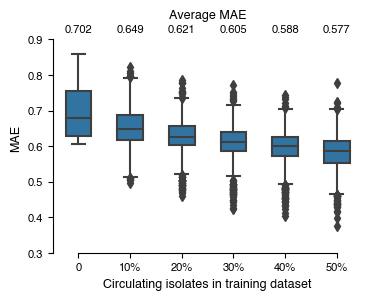

In [15]:
fig, ax = plt.subplots(figsize=(4,3))

plot = sns.boxplot(x='circ_train', y='MAE', data=scores[scores.season!='Average'],
                   width=0.5,
                   color="C0",
                   ax=ax)

# annotate
for (xtick, label) in zip(plot.get_xticks(), scores[scores.season=='Average'].groupby(['circ_train']).mean().MAE):
    ax.text(xtick,
            0.92,
            f"{label:.3f}",
            horizontalalignment='center',
            fontsize=8,
            rotation=0)

ax.text(2.5, 0.96, "Average MAE", fontsize=9, horizontalalignment='center')

# configurations for figure
ax.set_xlabel('Circulating isolates in training dataset', fontsize=9)
ax.set_ylabel('MAE', fontsize=9)
ax.set_ylim(bottom=0.3, top=0.95)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')